In [7]:
%load_ext autoreload
%autoreload 2
%aimport mcfost
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from numpy import unravel_index
import astropy.units as unit
import pysynphot
import os
from sh import gunzip
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib import ticker, cm 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def dustvar(File_array):
    Irb_array=[]
    l=len(File_array)
    for i in range(0,l):
        #IR Excess
        #filename=File_array[i]+'data_th/sed_rt.fits.gz'
        #gunzip(filename)
        mb=fits.open(File_array[i]+'data_th/sed_rt.fits')
        wavb=mb[1].data
        mb_flux=mb[0].data[0]
        modelb = pysynphot.ArraySpectrum(wavb, mb_flux.flatten(), name='model_b-spectra',fluxunits='flam',waveunits='microns')
        #Star Spectra
        star = fits.open(File_array[i]+'data_th/sed_rt.fits')
        wav=star[1].data
        star_f=star[0].data[1]
        sp = pysynphot.ArraySpectrum(wav, star_f.flatten(), name='Star-spectra',fluxunits='flam',waveunits='microns')
    
        c=2.99792*10**14
        mb_jy=10**26*modelb.flux*modelb.wave/c
        st_jy=10**26*sp.flux*sp.wave/c
        Irb=mb_jy-st_jy
        Irb_array.append(Irb)
    return(Irb_array)

In [9]:
Main_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band/'
#Dust=['Astrosil_DHS/','Olivines_DHS/','Ice_DHS/','Graphite_DHS/','Carbon_DHS/']
#Dust=['Astrosil_Olivine_DHS/','Astrosil_Olivine_Mie/']
Dust=['Astrosil/','Olivines/','Astrosil_Olivines/','Carbon/','Graphite/']
n=len(Dust)
Dust_dir=[]
for i in range(0,n):
    d_dir=Main_dir+Dust[i]
    Dust_dir.append(d_dir)

In [10]:
irb_array=dustvar(Dust_dir)

In [11]:
file_dir=Dust_dir[0]
mb=fits.open(file_dir+'data_th/sed_rt.fits')
wavb=mb[1].data
mb_flux=mb[0].data[0]
modelb = pysynphot.ArraySpectrum(wavb, mb_flux.flatten(), name='model_b-spectra',fluxunits='flam',waveunits='microns')
#Star Spectra
star = fits.open(file_dir+'data_th/sed_rt.fits')
wav=star[1].data
star_f=star[0].data[1]
sp = pysynphot.ArraySpectrum(wav, star_f.flatten(), name='Star-spectra',fluxunits='flam',waveunits='microns')

In [12]:
obsflux_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/'
b5sed=np.genfromtxt(obsflux_dir+"backman_fig_5.csv",delimiter=",")
b5sedinset=np.genfromtxt(obsflux_dir+"backman_fig_5_inset.csv",delimiter=",")

In [13]:
#Observed flux-Kate Su
obs_ir=np.genfromtxt(obsflux_dir+"EPSERI_wholeSED_measurements.csv",delimiter=",")
obs_wav=obs_ir[5:24,0]
obs_irex=obs_ir[5:24,3]/1000
obs_irerr=obs_ir[5:24,2]/1000

In [14]:
#irs_measurements
irs_file=np.genfromtxt(obsflux_dir+"EPSERI_IRE_IRS_measurements.csv",delimiter=",")
wav=irs_file[:,0]
irs=irs_file[:,1]/1000
irs_err=irs_file[:,2]/1000

In [9]:
fig_dir=obsflux_dir+'Figures/'

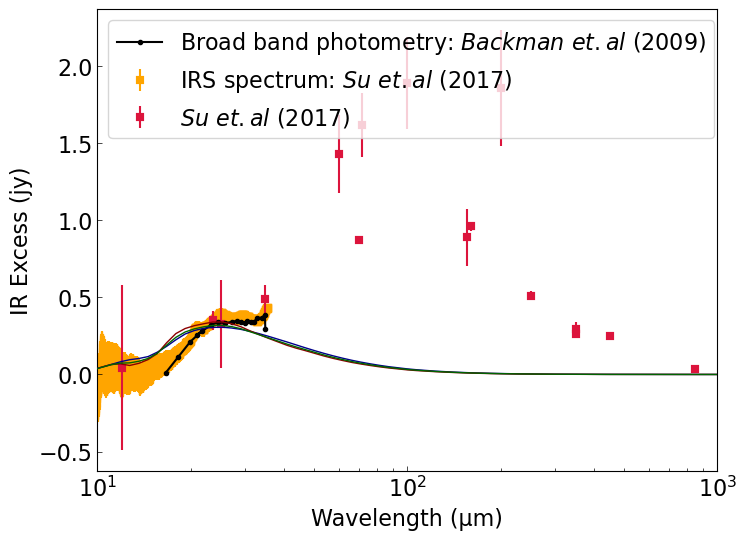

In [11]:
fig=plt.figure(figsize=(8,6))
ax2=fig.add_subplot(111)
#ax2.yaxis.set_ticks_position('both')
#ax2.xaxis.set_ticks_position('both')
#ax2.minorticks_on()
#ax2.tick_params(which='both', direction='in', width=0.5)
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax2.semilogx(modelb.wave,irb_array[0],ls='solid', color='darkblue',linewidth=1,zorder=10)
ax2.semilogx(modelb.wave,irb_array[1],ls='solid', color='darkred',linewidth=1,zorder=10)
ax2.semilogx(modelb.wave,irb_array[2],ls='solid', color='darkgreen',linewidth=1,zorder=10)
#ax2.semilogx(modelb.wave,irb_array[3],ls='dashdot', color='darkviolet',zorder=10,linewidth=1)
#ax2.semilogx(modelb.wave,irb_array[4],'*', color='royalblue',linewidth=1,zorder=10)
ax2.semilogx(b5sedinset[:,0],b5sedinset[:,1],".-",label="Broad band photometry: $Backman~et.al~(2009)$",color="black",zorder=5)
ax2.semilogx(wav,irs,ls='None',color='orange',zorder=0)
ax2.errorbar(wav,irs,yerr=irs_err,ls='None',marker='s',ms=3, mew=3,label="IRS spectrum: $Su~et.al~(2017)$",mfc='orange',mec='orange',ecolor='orange',zorder=0)
ax2.errorbar(obs_wav,obs_irex,yerr=obs_irerr,ls='None',ms=3, mew=3,marker='s',mfc='crimson',mec='crimson', ecolor='crimson',label="$Su~et.al~(2017)$")
ax2.set_xlim([10,1000])
ax2.set_xlabel('Wavelength (\u03BCm)',fontsize=16)
ax2.set_ylabel('IR Excess (jy)',fontsize=16)
ax2.legend(loc='upper left',fontsize=16)
fig.savefig(fig_dir+'sed_dust_var.pdf', format='pdf', bbox_inches='tight')

In [15]:
def scat_phas(file_array):
    scatph_wav_list=[]
    pol_wav_list=[]
    fdir=file_array
    l=len(file_array)
    for i in range (l):
        phase_func=fits.getdata(fdir[i]+'phase_function.fits')
        pol=fits.getdata(fdir[i]+'polarizability.fits')
        lam_mie=fits.getdata(fdir[i]+'lambda.fits')
        scatph_wav=phase_func[1:181,25]
        pol_wav=pol[1:181,25]
        
        scatph_wav_list.append(scatph_wav)
        pol_wav_list.append(pol_wav)
        
       
    return(scatph_wav_list,pol_wav_list)
    

In [16]:
Main_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band/'
#Sub_dir='/575nm/data_0.575/'
dust=['Astrosil/','Olivines/','Astrosil_Olivines/','Carbon/','Graphite/']
#dust=['Carbon/']
n=len(dust)
dust_dir=[]
for i in range(0,n):
    d_dir=Main_dir+dust[i]+'data_dust/'
    dust_dir.append(d_dir)

In [17]:
lam_mie=fits.getdata(dust_dir[0]+'lambda.fits')
dust_prop=scat_phas(dust_dir)
scat=dust_prop[0]
pol=dust_prop[1]


In [18]:
Main_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/Revision/'
fig_dir=Main_dir+'Figures/'

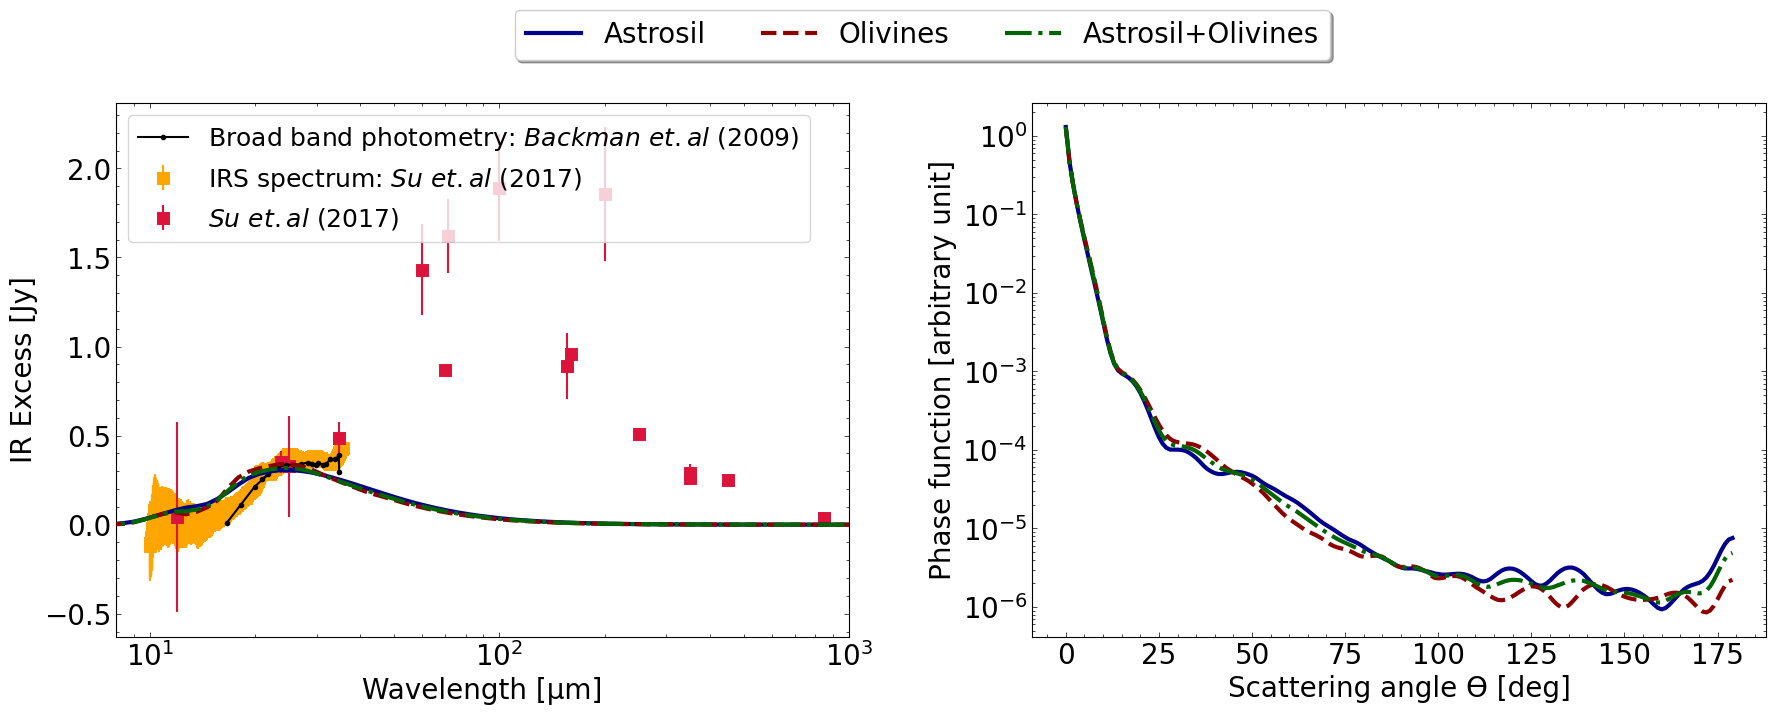

In [22]:
fig=plt.figure(figsize=(20,6))

ax2=fig.add_subplot(121)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5)
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=20)
ax2.semilogx(modelb.wave,irb_array[0],ls='solid', color='darkblue',linewidth=3,zorder=10)
ax2.semilogx(modelb.wave,irb_array[1],ls='dashed', color='darkred',linewidth=3,zorder=10)
ax2.semilogx(modelb.wave,irb_array[2],ls='dashdot', color='darkgreen',linewidth=3,zorder=10)
#ax2.semilogx(modelb.wave,irb_array[3],ls='dashdot', color='darkviolet',zorder=10,linewidth=1)
#ax2.semilogx(modelb.wave,irb_array[4],'*', color='royalblue',linewidth=1,zorder=10)
ax2.semilogx(b5sedinset[:,0],b5sedinset[:,1],".-",label="Broad band photometry: $Backman~et.al~(2009)$",color="black",zorder=5)
ax2.semilogx(wav,irs,ls='None',color='orange',zorder=0)
ax2.errorbar(wav,irs,yerr=irs_err,ls='None',marker='s',ms=5, mew=5,label="IRS spectrum: $Su~et.al~(2017)$",mfc='orange',mec='orange',ecolor='orange',zorder=0)
ax2.errorbar(obs_wav,obs_irex,yerr=obs_irerr,ls='None',ms=5, mew=5,marker='s',mfc='crimson',mec='crimson', ecolor='crimson',label="$Su~et.al~(2017)$")
ax2.set_xlim([8,1000])
ax2.set_xlabel('Wavelength [\u03BCm]',fontsize=20)
ax2.set_ylabel('IR Excess [Jy]',fontsize=20)
ax2.legend(loc='upper left',fontsize=18)




ax2=fig.add_subplot(122)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=20)
ax2.semilogy(scat[0],ls='solid', color='darkblue',label='Astrosil',linewidth=3)
ax2.semilogy(scat[1],ls='dashed', color='darkred',label='Olivines',linewidth=3)
ax2.semilogy(scat[2],ls='dashdot', color='darkgreen',label='Astrosil+Olivines',linewidth=3)
#ax2.semilogy(scat[3],ls='dashdot', color='darkviolet',label='Carbon',linewidth=2)
#ax2.semilogy(scat[4],'*', color='royalblue',label='Graphite',linewidth=1)
ax2.set_ylabel('Phase function [arbitrary unit]',fontsize=20)
ax2.set_xlabel('Scattering angle \u03F4 [deg]',fontsize=20)
#ax2.set_title('Scattering phase function',fontsize=16)
ax2.legend(loc='upper center',bbox_to_anchor=(-0.15,1.2),fontsize=20,ncol=3, fancybox=True, shadow=True)
ax2.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax2.ticklabel_format(style='plain',axis='x')
fig.subplots_adjust(hspace=0.2, wspace=0.25, top=1, right=0.95)
fig.savefig(fig_dir+'irexcess_scat_phas_epseri.pdf', format='pdf', bbox_inches='tight')